In [25]:
import findspark
findspark.init("/home/wesmail/Panda/spark-2.2.1-bin-hadoop2.7")

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *

spark = SparkSession.builder  \
.master("local[4]")  \
.appName("Multiclass Classification")  \
.config("spark.executor.memory","2gb")  \
.getOrCreate()

sc = spark.sparkContext

In [1]:
import numpy as np
from root_numpy import root2array, tree2array, rec2array
import pandas as pd

branch_names = '''momentumx, momentumy,momentumz,momentum,energy,position,MvdDEDX,MvdHits,SttMeanDEDX,SttHits,GemHits,TofStopTime,
TofM2,TofTrackLength,TofQuality,TofBeta,DrcThetaC,DrcQuality,
DiscThetaC,DiscQuality,
EmcRawEnergy,EmcCalEnergy,EmcQuality,EmcNumberOfCrystals,EmcNumberOfBumps,EmcModule,
EmcZ20,EmcZ53,EmcLat,EmcE1,EmcE9,EmcE25,MuoQuality,MuoIron,MuoMomentumIn,MuoNumberOfLayers,MuoModule,MuoHits,
DegreesOfFreedom,ChiSquared'''.split(",")

branch_names = [c.strip() for c in branch_names]
branch_names = list(branch_names)

electrons = root2array("/home/wesmail/Downloads/treeElectrons.root", "t1", branch_names)
electrons = rec2array(electrons)

pions = root2array("/home/wesmail/Downloads/treePions.root", "t1", branch_names)
pions = rec2array(pions)

muons = root2array("/home/wesmail/Downloads/treeMuons.root", "t1", branch_names)
muons = rec2array(muons)

kaons = root2array("/home/wesmail/Downloads/treeKaons.root", "t1", branch_names)
kaons = rec2array(kaons)

anti_p = root2array("/home/wesmail/Downloads/treeProtons.root", "t1", branch_names)
anti_p = rec2array(anti_p)

X = np.concatenate((electrons, pions, muons, kaons, anti_p))
y = np.concatenate(( np.zeros(electrons.shape[0]),np.ones(pions.shape[0]), (2*np.ones(muons.shape[0])), (3*np.ones(kaons.shape[0])), (4*np.ones(anti_p.shape[0])) ))
df = pd.DataFrame(np.hstack((X, y.reshape(y.shape[0], -1))),columns=branch_names+['temp'])

df['Momentum'] = np.sqrt(df.loc[:,'momentum']) 
df = df.drop(['momentum'], axis=1)
df['E9/E25'] = df.loc[:,'EmcE9']/df.loc[:,'EmcE25']
df['E1/E25'] = df.loc[:,'EmcE1']/df.loc[:,'EmcE25']
df['E/p'] = df.loc[:,'EmcCalEnergy']/df.loc[:,'Momentum']
df['labels'] = df.loc[:,'temp']
df = df.drop(['temp'], axis=1)
df = df.dropna()

from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1], test_size=0.30, random_state=0)

Welcome to ROOTaaS 6.06/02


In [6]:
from spark_sklearn import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

#dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=0.05*len(X_train))
#bdt = AdaBoostClassifier(dt,algorithm='SAMME',n_estimators=800,learning_rate=0.5)

#param_grid = {'max_depth': np.arange(1,30,1), 'n_estimators': np.arange(100,1001,100),
#             'max_features': np.arange(5,30,2), 'learning_rate': np.arange(0.1,0.6,0.1)}

#param_grid = {'max_depth': np.arange(1,30,1)}

#bdt = GradientBoostingClassifier(max_depth=9, n_estimators=1000, learning_rate=0.4, max_features=23, random_state=0)
#clf = GridSearchCV(sc, bdt, param_grid=param_grid, n_jobs=4) # remember I removed cv=3, preferably cv=5 or 10

In [4]:
bdt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.4, loss='deviance', max_depth=9,
              max_features=23, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = bdt.decision_function(X_test)
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [39]:
y_predicted = bdt.predict(X_train)
from sklearn.metrics import accuracy_score
print("The score accuracy on BDT (max_depth=10) is:  %.4f"%accuracy_score(y_train,y_predicted))

The score accuracy on BDT (max_depth=10) is:  1.0000


In [2]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=2, criterion='entropy')
bdt = model.fit(X_train, y_train)
#bdt = tree.DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

In [3]:
import graphviz

dot_data = tree.export_graphviz(bdt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("bdt") 

'bdt.pdf'

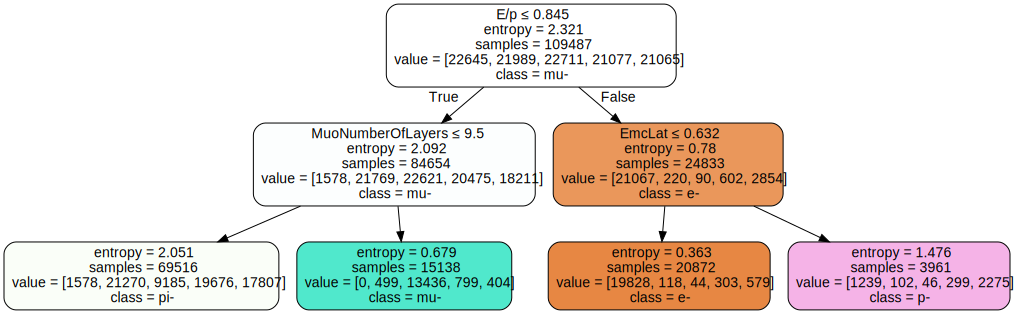

In [9]:
%matplotlib tk
#df = df.drop(['labels'], axis=1)
cols = list(df.columns)

dot_data = tree.export_graphviz(bdt, out_file=None, 
                         filled=True, rounded=True,
                         feature_names=cols,
                         class_names=['e-','pi-', 'mu-', 'k-', 'p-'],
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("bdt") 
graph 

In [38]:
figfi = plt.figure()
plt.plot(bdt.feature_importances_, 'o', color='red', markersize=15)
plt.xticks(range(X.shape[1]), branch_names, rotation=90 )
plt.ylim(0,1)

(0, 1)